# Retrieval Agent

A notebook to explain how the retrieval Agent works

In [1]:
from langchain_ollama import OllamaEmbeddings, ChatOllama
from langchain_chroma import Chroma

## Tool

The retrieval agent will consist of a ChatOllama model from langchain, provided with tools. A tool is a simpl function the model is allowed to use, such as a multiplication function. In our case, the function will consist of a query sent to a knowledge base to retrieve the closest documents.

We first create the retriever to communnicate with the vector database.

In [2]:

VECTORSTORE_DIR = "../src/user_data/vectorstore/"

embeddings = OllamaEmbeddings(model="nomic-embed-text", num_ctx=4096) 
# Context window size, default 2048 seems to trigger "decode: cannot decode
# batches with this context (use llama_encode() instead)" in Ollama

# Found in src/core/retrieval.py

COLLECTION = "HOMER"
COLLECTION_METADATA = {"hnsw:space": "cosine"}

vector_store = Chroma(
  collection_name = COLLECTION,
  collection_metadata= COLLECTION_METADATA,
  embedding_function = embeddings,
  persist_directory = VECTORSTORE_DIR,  # Where to save data locally
)

retriever = vector_store.as_retriever(
  )

We then create the function, which takes a string as input and outputs all the retrieved documents as a string as well.

In [3]:
def context_search(query: str) -> str:
    """
    Contextual search in the knowledge base.

    This function sends a query to a vector search engine (retriever) and 
    returns the k most relevant documents as formatted text. The model should
    call this tool whenever the user’s request requires information stored in 
    the knowledge base.

    Args:
        query (str): The search query generated by the model.
            - It should be short and focused (e.g., "Flask deployment steps",
              "summary of project X meeting", "Cron job configuration").
            - The model SHOULD NOT pass the full user question; it should 
              extract the essential information need from it.

    Returns:
        str: A formatted text string containing the relevant documents, 
        intended to be used by the model to craft the final answer to the user.
    """
    
    docs=retriever.invoke(input=query)
    if docs:
        from ..src.utils.utils import format_docs
        context = format_docs(docs=docs)
        return context
    return "No relevant context found."

tools = [context_search]

## States

The state will be passed down each nodes and updated. The input state can be different from the output state.

In [4]:
from langgraph.graph import MessagesState

class State(MessagesState):
    messages: str

## Nodes

### Tool node
The tool node is a function called "context_search" which will perform a 
search in a chromaDB vectorstore. It will be called by the main model node.

In [5]:
SYSTEM_PROMPT = """You are Homer, an AI assistant that helps users find information in their 
personal knowledge base.

You have access to a tool called `context_search` that lets you retrieve relevant
documents. Use this tool whenever the user asks a question that may require 
information stored in the knowledge base.

### How to use the tool
- Before answering, determine whether external information is needed.
- If yes, generate a short and focused search query (not the full user input).  
- The search query should reflect the *core concept* the user is looking for.  
- Then call `context_search` with that query.
- Use the returned documents to build a clear and accurate answer.
- The tool may return "No relevant context found." if nothing matches. Then answer the user with your own knowledge.

### Example of tool usage
User question: "How do I deploy my API Flask ?"
→ Search query generated: `"Flask API deployment steps"`

The model would then call:
`context_search(query="Flask API deployment steps")`

And then you can answer the user with the given context.

---

### Role behavior
- If the answer is directly known without the KB, you may answer directly.
- Otherwise, use the tool.
- Do NOT invent information that is not present in the retrieved documents.

---
"""

In [6]:
model = ChatOllama(model="qwen3", #    "qwen3:0.6b",
                   temperature=0,
                   #num_ctx=8192
).bind_tools(tools)

In [7]:
from langchain_core.messages import SystemMessage, HumanMessage

def call_model(state: State):
    messages = state["messages"] +[SystemMessage(content=SYSTEM_PROMPT)]
    response = model.invoke(messages)
    return {"messages": [response]}

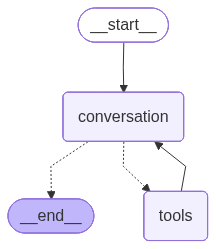

In [8]:
from IPython.display import Image, display
from langgraph.prebuilt import tools_condition
from langgraph.prebuilt import ToolNode
from langgraph.graph import StateGraph, START, END

# Define a new graph
workflow = StateGraph(State)
workflow.add_node("conversation", call_model)
workflow.add_node("tools", ToolNode(tools))

# Set the entrypoint as conversation
workflow.add_edge(START, "conversation")
workflow.add_conditional_edges(
    "conversation",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)
workflow.add_edge("tools", "conversation")
workflow.add_edge("conversation", END)

# Compile
#memory = MemorySaver()
#graph = workflow.compile(checkpointer=memory)
graph = workflow.compile()
display(Image(graph.get_graph().draw_mermaid_png()))

In [9]:
input = {
    "messages":[HumanMessage(content="Hello what is the MYRRHA project?")]
}
for chunk, metadata in graph.stream(
    input=input,
    stream_mode="messages", # Stream the "messages" value of the graph state
):
    if chunk.content and metadata["langgraph_node"] == "conversation":
        print(chunk.content,end='',flush=True)


The knowledge base does not contain the information you're asking about. Please provide a different question or check if the topic is correctly specified. I can assist with general knowledge or clarify your request!

It is possible that the qwen3:0.6b model does not use at all the tool. That model is very small and may not understand completely the prompts.

In [10]:
input = {
    "messages":[HumanMessage(content="Hello what is the MYRRHA project?")]
}
for update in graph.stream(
    input=input,
    stream_mode="debug", # Stream the "messages" value of the graph state
):
    print(update)

{'step': 1, 'timestamp': '2025-11-21T18:17:21.845864+00:00', 'type': 'task', 'payload': {'id': '9bd14dec-c1db-9766-12cc-3fe66197f49a', 'name': 'conversation', 'input': {'messages': [HumanMessage(content='Hello what is the MYRRHA project?', additional_kwargs={}, response_metadata={})]}, 'triggers': ('branch:to:conversation',)}}


{'step': 1, 'timestamp': '2025-11-21T18:17:28.693647+00:00', 'type': 'task_result', 'payload': {'id': '9bd14dec-c1db-9766-12cc-3fe66197f49a', 'name': 'conversation', 'error': None, 'result': {'messages': [AIMessage(content='', additional_kwargs={}, response_metadata={'model': 'qwen3', 'created_at': '2025-11-21T18:17:28.6926882Z', 'done': True, 'done_reason': 'stop', 'total_duration': 6845222900, 'load_duration': 75164100, 'prompt_eval_count': 526, 'prompt_eval_duration': 32127900, 'eval_count': 313, 'eval_duration': 6699903300, 'logprobs': None, 'model_name': 'qwen3', 'model_provider': 'ollama'}, id='lc_run--2ad2035e-d0d1-420f-a0d7-e1b98c7b565d-0', tool_calls=[{'name': 'context_search', 'args': {'query': 'MYRRHA project summary'}, 'id': 'd2fa5581-2582-40da-bada-fb20534ac7b2', 'type': 'tool_call'}], usage_metadata={'input_tokens': 526, 'output_tokens': 313, 'total_tokens': 839})]}, 'interrupts': []}}
{'step': 2, 'timestamp': '2025-11-21T18:17:28.693795+00:00', 'type': 'task', 'payload':